In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose

# Sensors 2, 6, 8, 9, 10, 11, 18 have valid records for all years, so start time series with these

In [11]:
sensors = pd.read_csv('./cleaned datasets/all_valid_sensors.csv')
sensors.head()

,year,month,day,weekday,hour,sensor_id,hourly_counts,datetime
0,2011,1,1,Saturday,0,2,985,2011-01-01 00:00:00
1,2011,1,1,Saturday,0,3,2547,2011-01-01 00:00:00
2,2011,1,1,Saturday,0,4,3514,2011-01-01 00:00:00
3,2011,1,1,Saturday,0,5,5021,2011-01-01 00:00:00
4,2011,1,1,Saturday,0,6,3514,2011-01-01 00:00:00


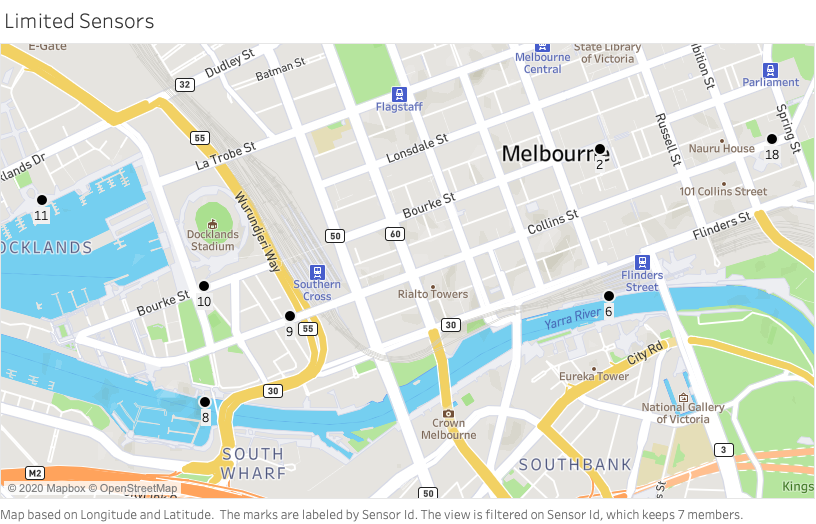

In [12]:
Image(filename = './visuals/limited_sensors_map.png')

## Functions

#### create heatmap for each sensor to understand trends

In [30]:
def heatmap_per_sensor(sensor_number): 
    sensor_x = sensors[sensors.sensor_id == sensor_number]
    piv = pd.pivot_table(sensor_x, values="hourly_counts",index=["weekday"], columns=["month"], fill_value=0)
    piv.index = pd.CategoricalIndex(piv.index, categories= ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    piv.sort_index(level=0, inplace=True)
    piv2 = pd.pivot_table(sensor_x, values="hourly_counts",index=["year"], columns=["month"], fill_value=1)
    piv2.sort_index(level=0, inplace=True)

    #plot pivot table as heatmap using seaborn
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    sns.heatmap(piv, ax=ax1)
    ax1.set_title('sensor # {}'.format(sensor_number))
    sns.heatmap(piv2, ax=ax2)
    ax2.set_title('sensor # {}'.format(sensor_number))
    plt.tight_layout()
    plt.show()

#### returns data frame with average daily sensor counts for specified sensor

In [21]:
def daily_avg_ts(sensor_num):
    #get only time series data for sensor & make time series the index
    sensor = sensors[sensors.sensor_id ==sensor_num]
    sensor_time = sensor[['datetime', 'hourly_counts']]
    sensor_time.set_index('datetime', inplace = True)
    sensor_time.index = pd.DatetimeIndex(sensor_time.index).to_period('H')

    #resample to get daily average counts
    daily_sensor = sensor_time.resample('1D').mean()
    daily_sensor.dropna(inplace = True)
    
    #get only data from 2011-2018, predict 2019
    daily_sensor_2011_2018 = daily_sensor.loc['2011-01-01': '2018-12-31']
    return daily_sensor_2011_2018

#### plot daily time series & decomposition graphs

In [22]:
def time_series_plots(daily_sensor):
    daily_sensor.plot(figsize = (16,10));
    daily_sensor.interpolate(inplace = True)
    decomposition = seasonal_decompose(daily_sensor, model = 'additive', freq = 365)
    decomposition.plot()
    plt.show()

#### plot autocorrelation graphs

In [23]:
def autocorr_plots(y, lags=None):
    figure, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    plt.show()


#### find best parameters for time series, using only temp as an exog feature

In [24]:
def find_best_params(daily_sensor):
    
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    params = []
    param_seasonals = []
    all_results = []
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(daily_sensor,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit(maxiter = 10000)
                
                params.append(param)
                param_seasonals.append(param_seasonal)
                all_results.append(results.aic)
                
            except:
                continue
            

    df = pd.DataFrame({'parameters': params, 'seasonal parameters': param_seasonals, 'AIC': all_results})
    
    return df.sort_values(by = 'AIC')

#### return MSE & R2 Scores & forecast graph

In [25]:
def model_scores(daily_sensor = daily_avg_ts(2), order1 =1 , order2= 2, order3= 3, seasonal1 = 1, seasonal2=2, seasonal3 = 3, sensor_num = 2):
    model = sm.tsa.statespace.SARIMAX(daily_sensor,
                                  order=(order1, order2, order3), 
                                  seasonal_order=(seasonal1, seasonal2, seasonal3, 12)) 
    results = model.fit(maxiter=10000)
    results.summary()
    
    print('Root MSE: ', mean_squared_error(daily_sensor, results.predict())**0.5)
    print('R2 Score: ', r2_score(daily_sensor, results.predict()))
    
    preds = results.predict(start= '2018-01-01', end= '2019-12-31', dynamic=False)
    preds_dyn = results.predict(start= '2018-01-01', end= '2019-12-31', dynamic=True)
    
    # forecasting
    start_p = 50

    fig, ax = plt.subplots(figsize=(20, 16))
    daily_sensor.plot(c='b', label='Daily Sensor Count Means', lw=3, ax=ax)
    preds.plot(c='g', ls='--', lw=3, label='non-dynamical foreacasting', ax=ax)
    preds_dyn.plot(c='r', ls='-.', label='dynamical forecasting', ax=ax)
    plt.legend()
    #plt.savefig('sensor_{}_ts.png'.format(sensor_num))
    plt.show()


## Sensor 2

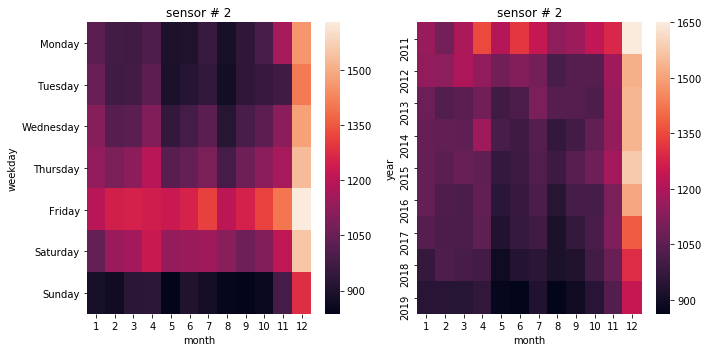

In [15]:
heatmap_per_sensor(2)

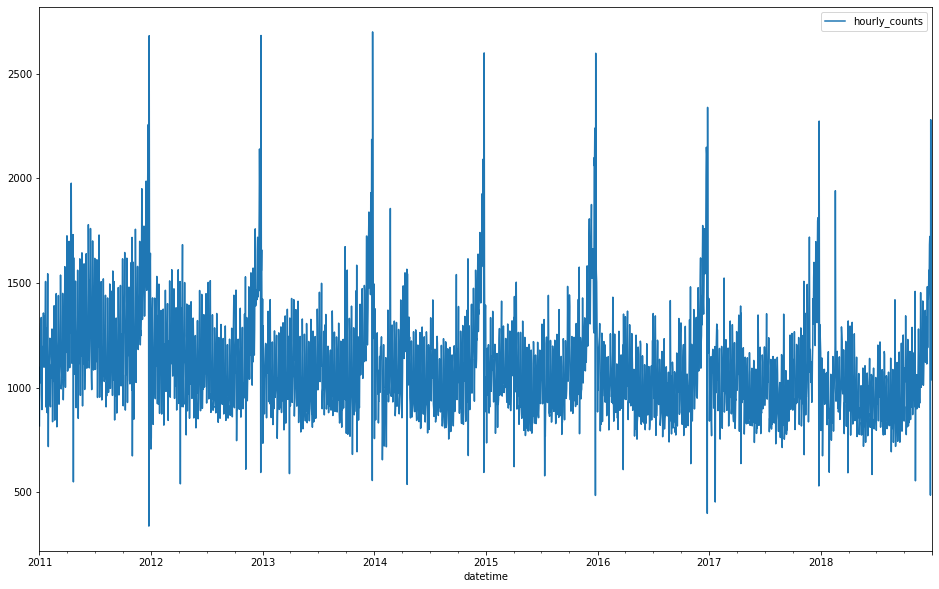

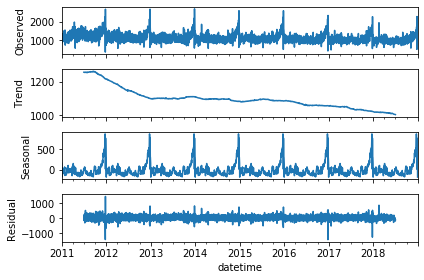

In [26]:
time_series_plots(daily_avg_ts(2))

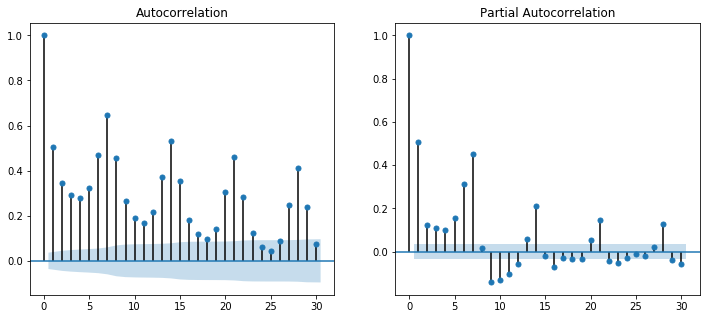

In [27]:
autocorr_plots(daily_avg_ts(2), lags=30)

In [28]:
find_best_params(daily_avg_ts(2))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,parameters,seasonal parameters,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",38911.292717
59,"(1, 1, 1)","(0, 1, 1, 12)",38951.804680
61,"(1, 1, 1)","(1, 0, 1, 12)",38957.434490
47,"(1, 0, 1)","(1, 1, 1, 12)",38974.550606
57,"(1, 1, 1)","(0, 0, 1, 12)",38987.091149
...,...,...,...
18,"(0, 1, 0)","(0, 1, 0, 12)",42469.429658
9,"(0, 0, 1)","(0, 0, 1, 12)",44244.230015
1,"(0, 0, 0)","(0, 0, 1, 12)",46190.620228
8,"(0, 0, 1)","(0, 0, 0, 12)",46223.908171


Root MSE:  201.58448827952085
R2 Score:  0.3170028733521483


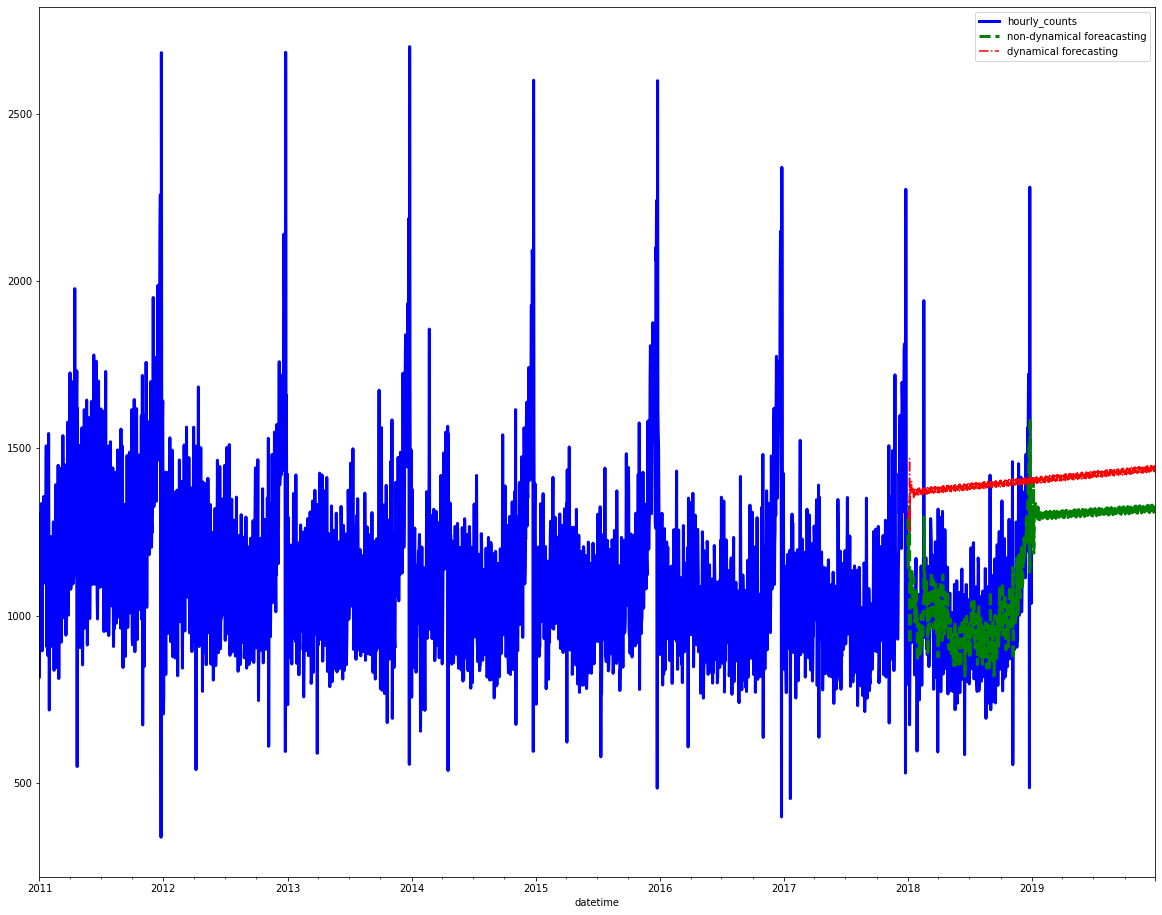

In [29]:
model_scores(daily_sensor = daily_avg_ts(2), order1 =1 , order2= 1, order3= 1, seasonal1 = 1, seasonal2=1, seasonal3 = 1, sensor_num = 2)



## Sensor 6

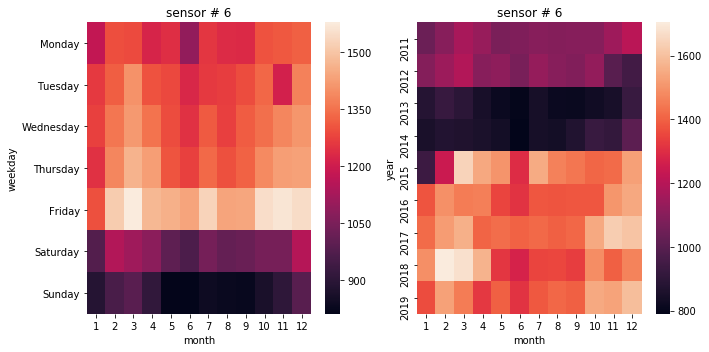

In [31]:
heatmap_per_sensor(6)

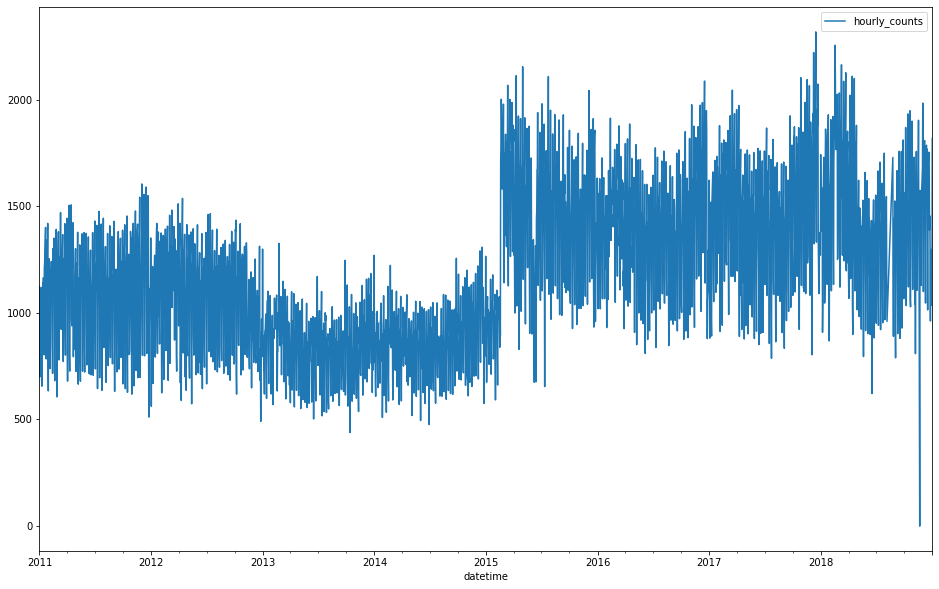

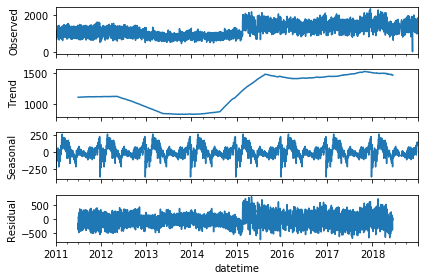

In [32]:
time_series_plots(daily_avg_ts(6))

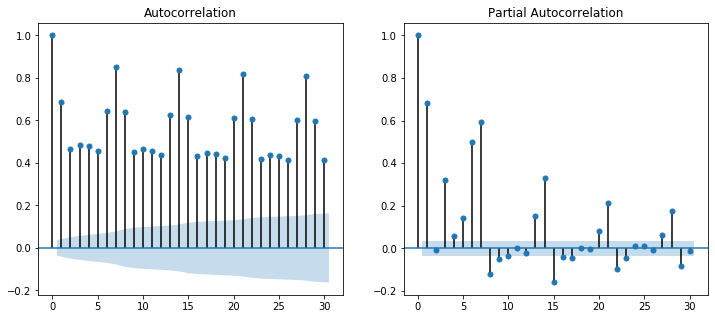

In [33]:
autocorr_plots(daily_avg_ts(6), lags=30)

In [34]:
find_best_params(daily_avg_ts(6))

,parameters,seasonal parameters,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",39253.358872
61,"(1, 1, 1)","(1, 0, 1, 12)",39255.438698
57,"(1, 1, 1)","(0, 0, 1, 12)",39262.668070
60,"(1, 1, 1)","(1, 0, 0, 12)",39373.157977
29,"(0, 1, 1)","(1, 0, 1, 12)",39438.396473
...,...,...,...
18,"(0, 1, 0)","(0, 1, 0, 12)",43555.663569
9,"(0, 0, 1)","(0, 0, 1, 12)",44280.738520
8,"(0, 0, 1)","(0, 0, 0, 12)",46328.272177
1,"(0, 0, 0)","(0, 0, 1, 12)",46666.684985


Root MSE:  245.641017259193
R2 Score:  0.5071770422332265


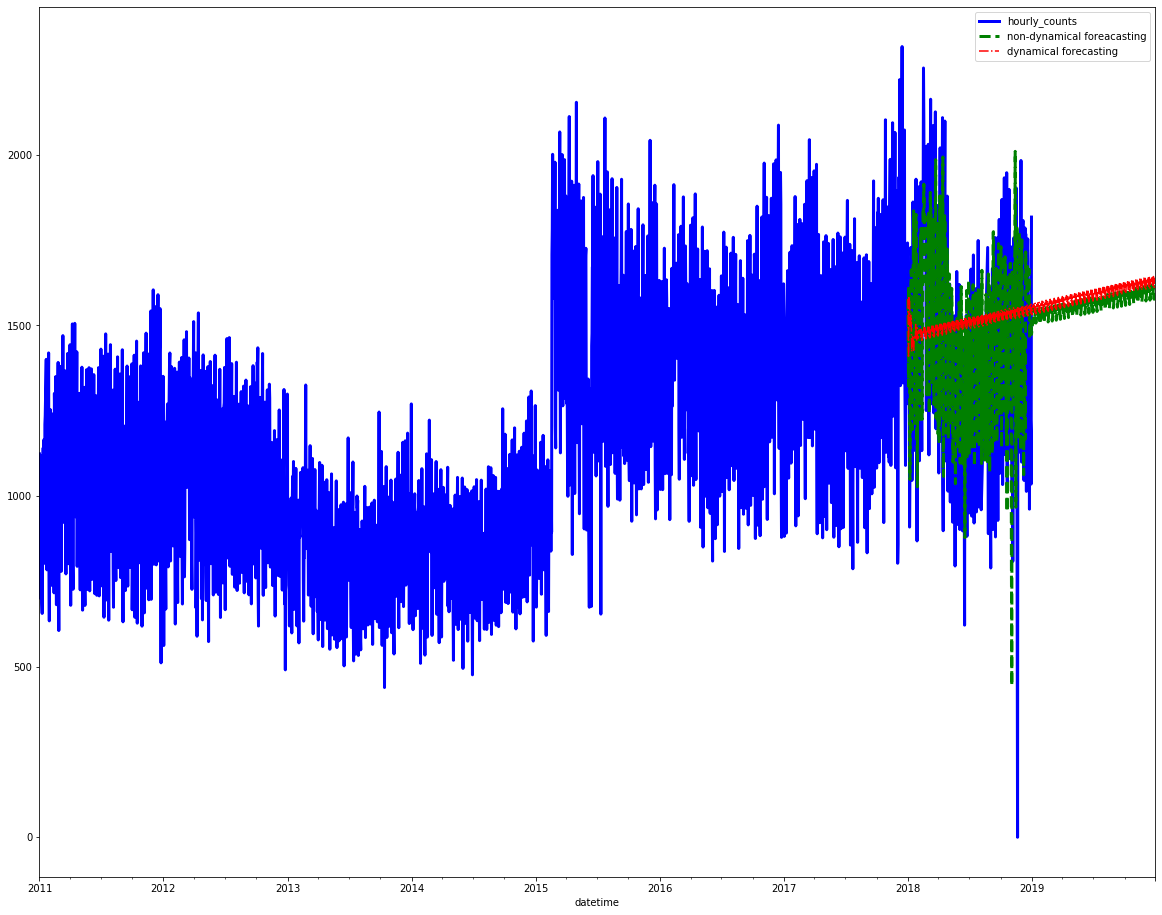

In [55]:
model_scores(daily_sensor = daily_avg_ts(6), order1 =1 , order2= 1, order3= 1, seasonal1 = 1, seasonal2=1, seasonal3 = 1, sensor_num = 6)



## Sensor 8

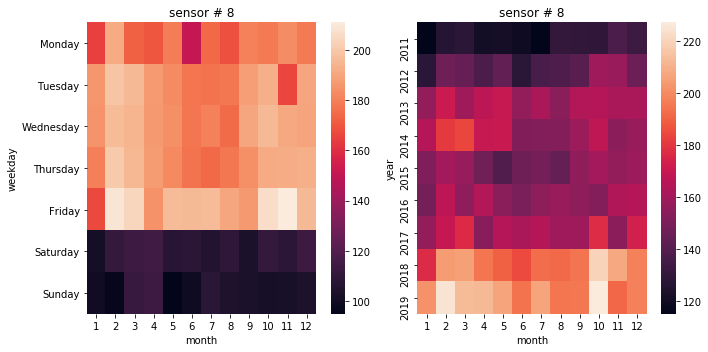

In [35]:
heatmap_per_sensor(8)

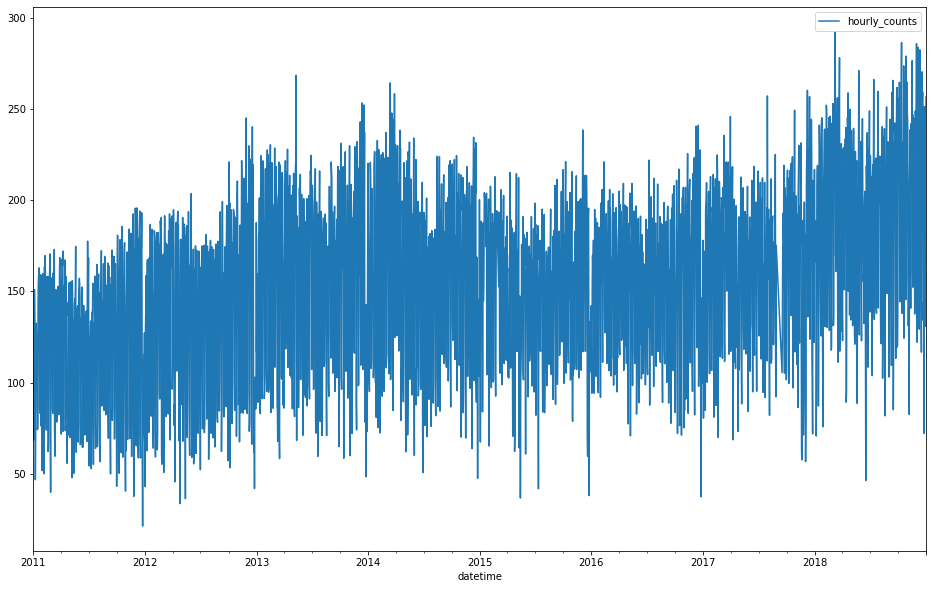

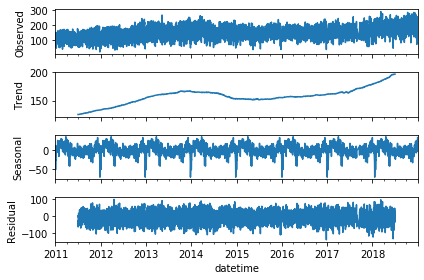

In [36]:
time_series_plots(daily_avg_ts(8))

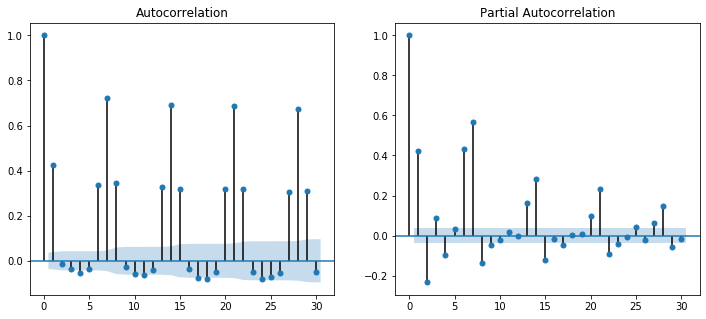

In [37]:
autocorr_plots(daily_avg_ts(8), lags=30)

In [38]:
find_best_params(daily_avg_ts(8))

,parameters,seasonal parameters,AIC
61,"(1, 1, 1)","(1, 0, 1, 12)",29532.022026
57,"(1, 1, 1)","(0, 0, 1, 12)",29548.144286
63,"(1, 1, 1)","(1, 1, 1, 12)",29609.639280
15,"(0, 0, 1)","(1, 1, 1, 12)",29610.024991
47,"(1, 0, 1)","(1, 1, 1, 12)",29611.910251
...,...,...,...
50,"(1, 1, 0)","(0, 1, 0, 12)",33777.074267
18,"(0, 1, 0)","(0, 1, 0, 12)",33794.927354
8,"(0, 0, 1)","(0, 0, 0, 12)",34753.245983
1,"(0, 0, 0)","(0, 0, 1, 12)",35357.533893


Root MSE:  40.58720112817032
R2 Score:  0.3187189430488614


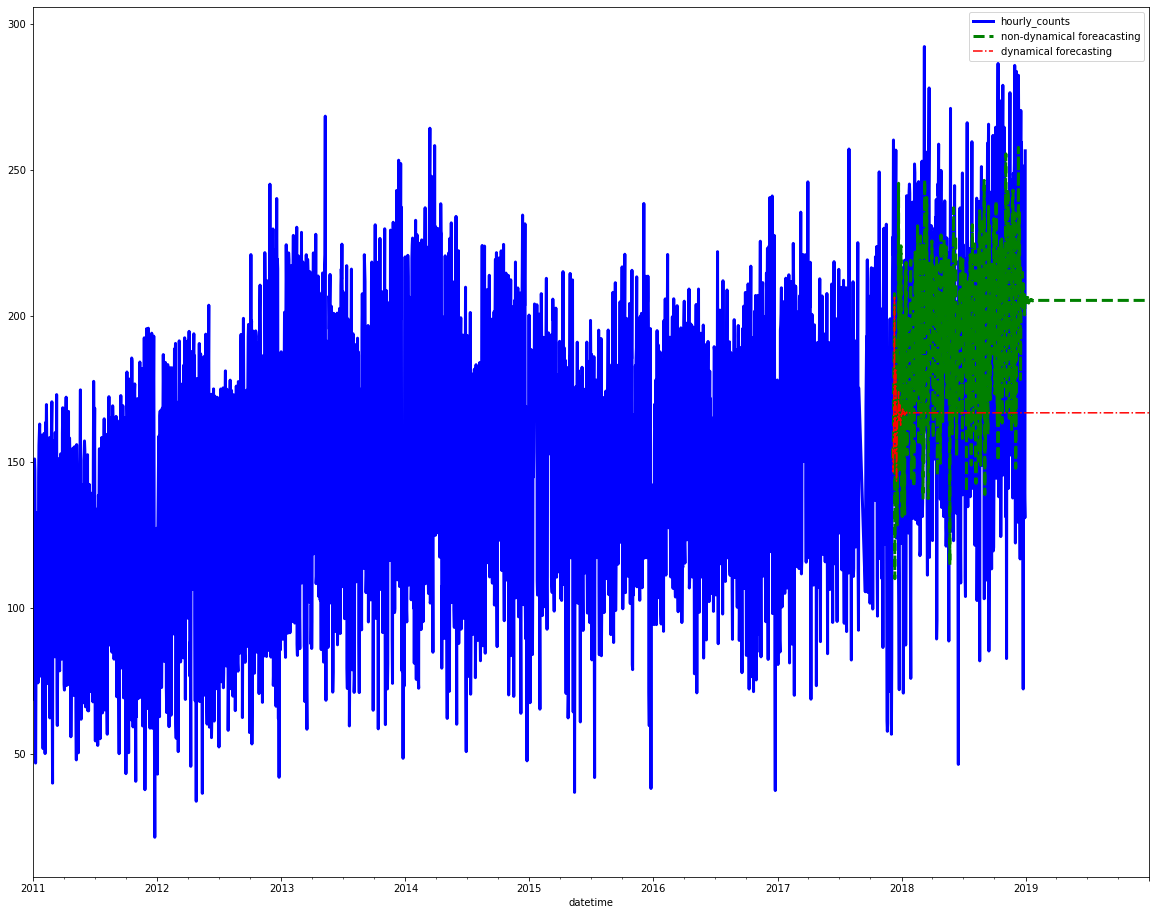

In [56]:
model_scores(daily_sensor = daily_avg_ts(8), order1 =1 , order2= 1, order3= 1, seasonal1 = 1, seasonal2=0, seasonal3 = 1, sensor_num = 8)



## Sensor 9

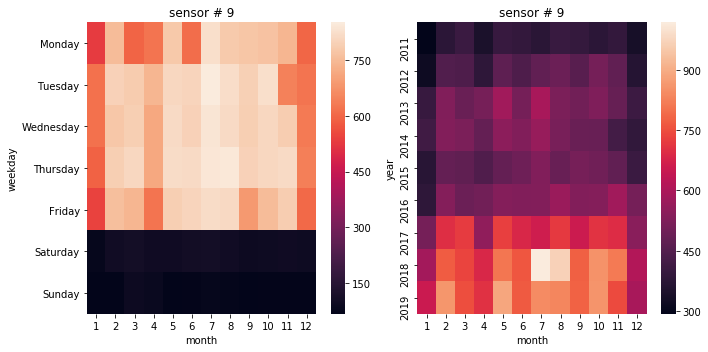

In [39]:
heatmap_per_sensor(9)

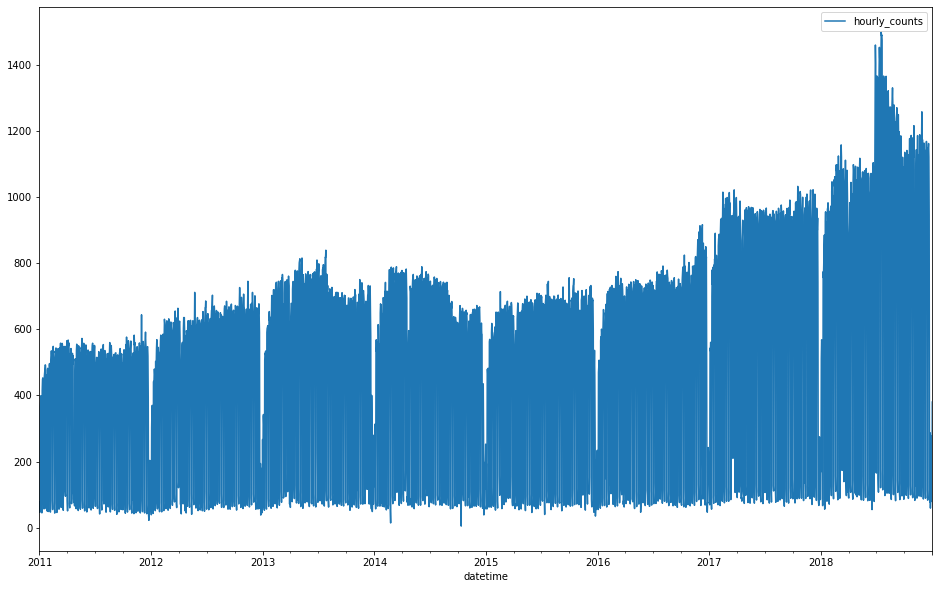

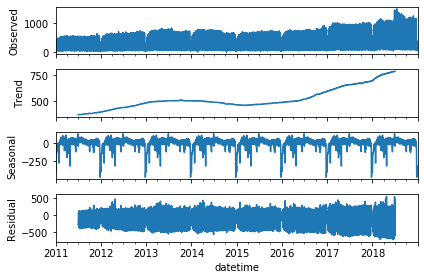

In [40]:
time_series_plots(daily_avg_ts(9))

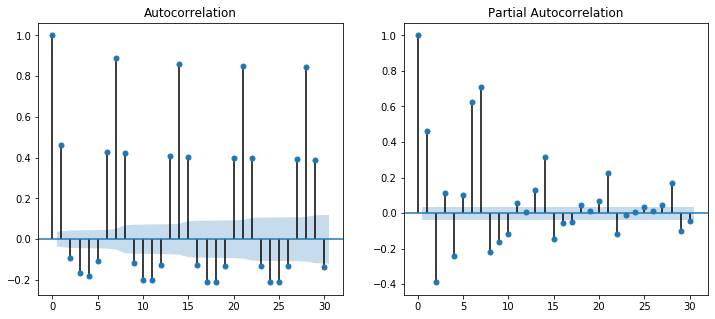

In [41]:
autocorr_plots(daily_avg_ts(9), lags=30)

In [42]:
find_best_params(daily_avg_ts(9))

,parameters,seasonal parameters,AIC
57,"(1, 1, 1)","(0, 0, 1, 12)",40530.865293
61,"(1, 1, 1)","(1, 0, 1, 12)",40532.375457
15,"(0, 0, 1)","(1, 1, 1, 12)",40650.861776
47,"(1, 0, 1)","(1, 1, 1, 12)",40651.282791
43,"(1, 0, 1)","(0, 1, 1, 12)",40786.090095
...,...,...,...
58,"(1, 1, 1)","(0, 1, 0, 12)",44878.048276
26,"(0, 1, 1)","(0, 1, 0, 12)",45309.418517
18,"(0, 1, 0)","(0, 1, 0, 12)",45496.474096
50,"(1, 1, 0)","(0, 1, 0, 12)",45498.123725


Root MSE:  256.8712732404006
R2 Score:  0.4436560526421053


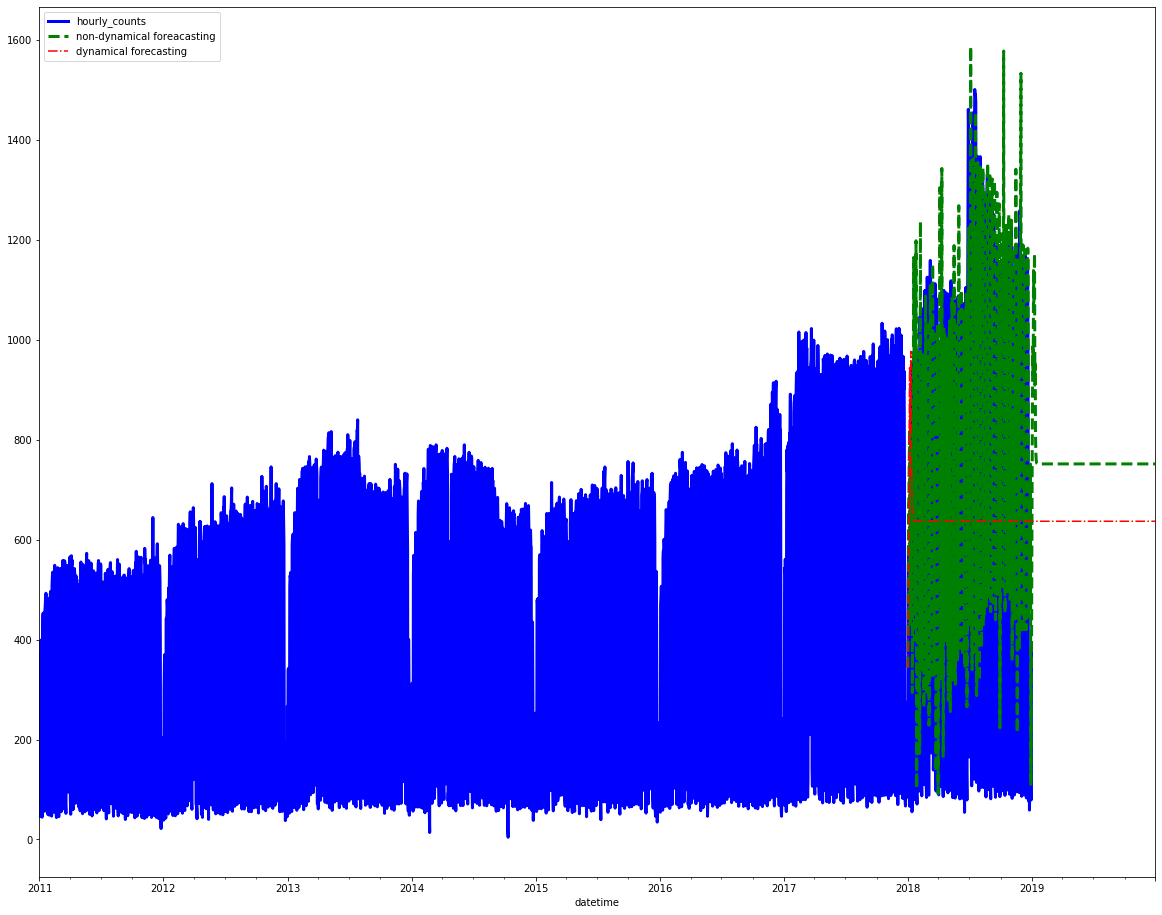

In [57]:
model_scores(daily_sensor = daily_avg_ts(9), order1 =1 , order2= 1, order3= 1, seasonal1 = 0, seasonal2=0, seasonal3 = 1, sensor_num = 9)



## Sensor 10

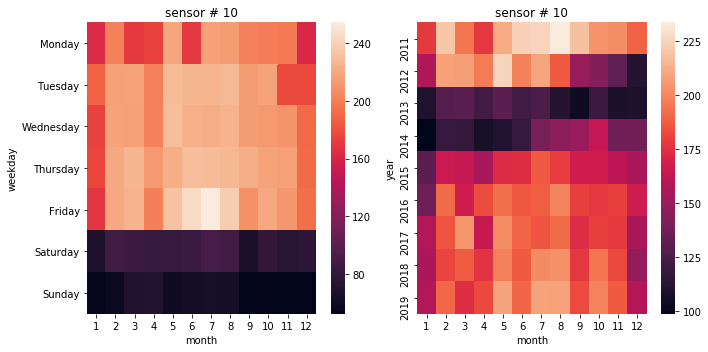

In [43]:
heatmap_per_sensor(10)

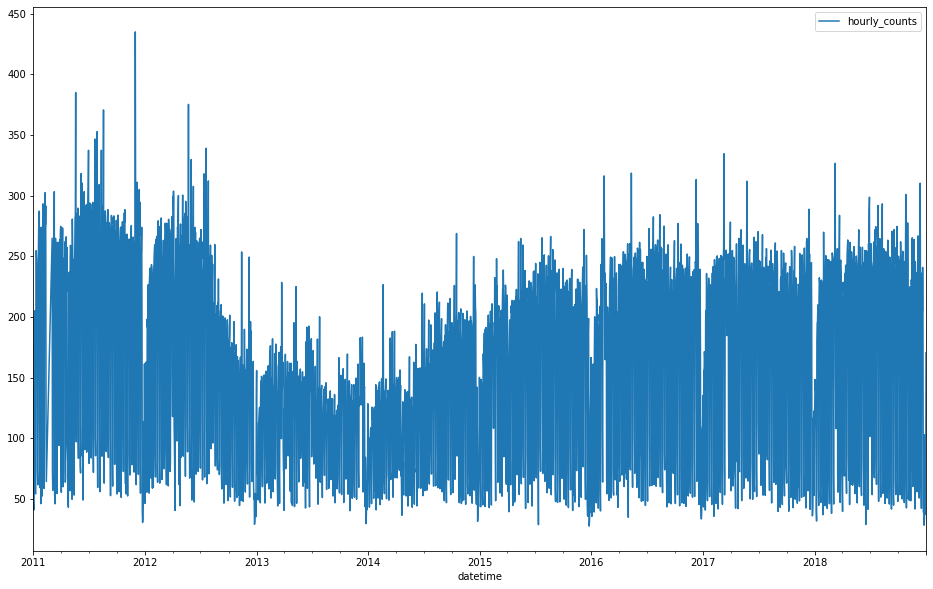

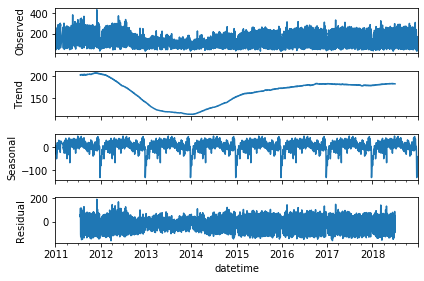

In [44]:
time_series_plots(daily_avg_ts(10))

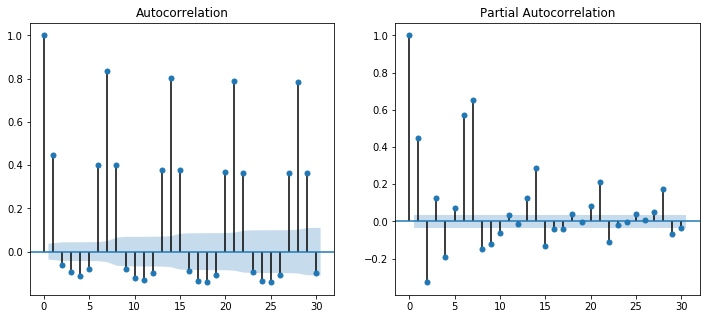

In [45]:
autocorr_plots(daily_avg_ts(10), lags=30)

In [46]:
find_best_params(daily_avg_ts(10))

,parameters,seasonal parameters,AIC
61,"(1, 1, 1)","(1, 0, 1, 12)",32047.888284
57,"(1, 1, 1)","(0, 0, 1, 12)",32048.526833
47,"(1, 0, 1)","(1, 1, 1, 12)",32206.889904
15,"(0, 0, 1)","(1, 1, 1, 12)",32207.125056
63,"(1, 1, 1)","(1, 1, 1, 12)",32257.907881
...,...,...,...
58,"(1, 1, 1)","(0, 1, 0, 12)",36324.883922
50,"(1, 1, 0)","(0, 1, 0, 12)",36781.617055
18,"(0, 1, 0)","(0, 1, 0, 12)",36782.500932
1,"(0, 0, 0)","(0, 0, 1, 12)",36849.005600


Root MSE:  62.04349352050366
R2 Score:  0.39421501799086756


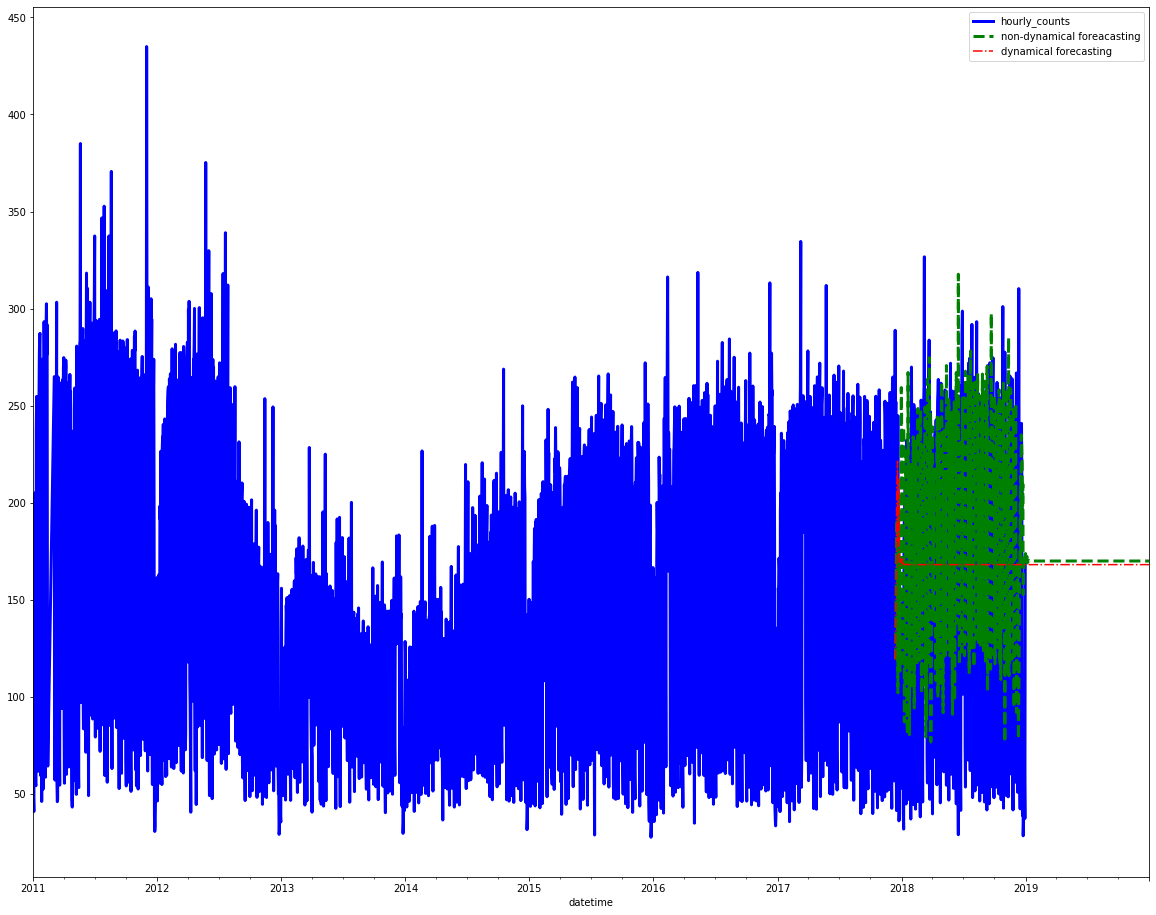

In [58]:
model_scores(daily_sensor = daily_avg_ts(10), order1 =1 , order2= 1, order3= 1, seasonal1 = 1, seasonal2=0, seasonal3 = 1, sensor_num = 10)



## Sensor 11

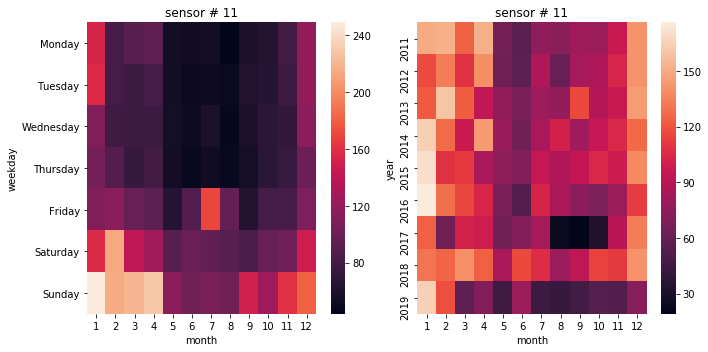

In [47]:
heatmap_per_sensor(11)

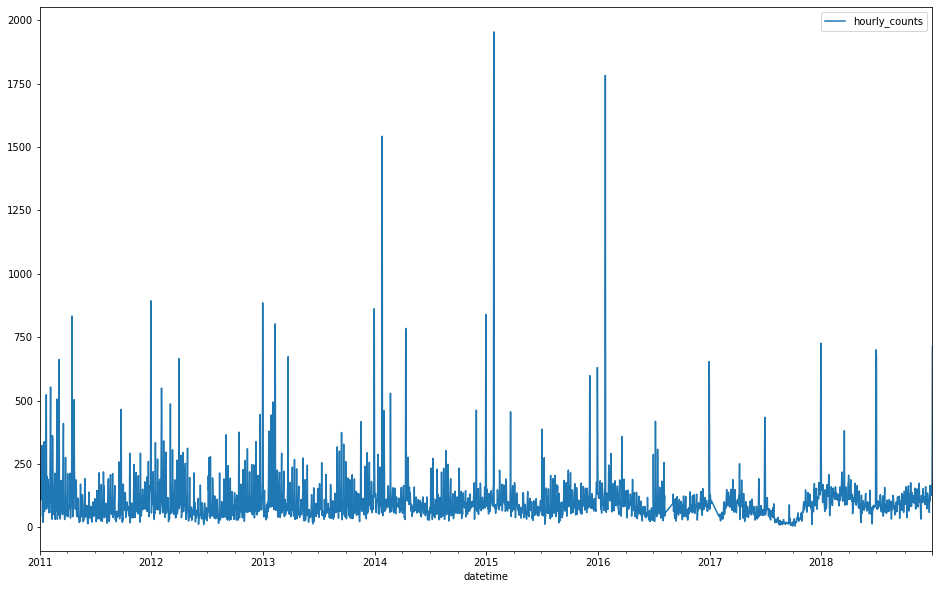

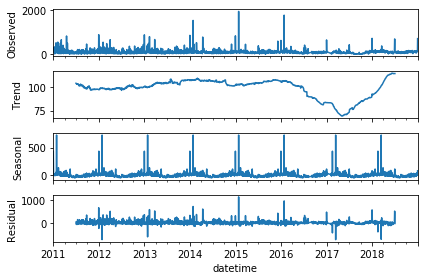

In [48]:
time_series_plots(daily_avg_ts(11))

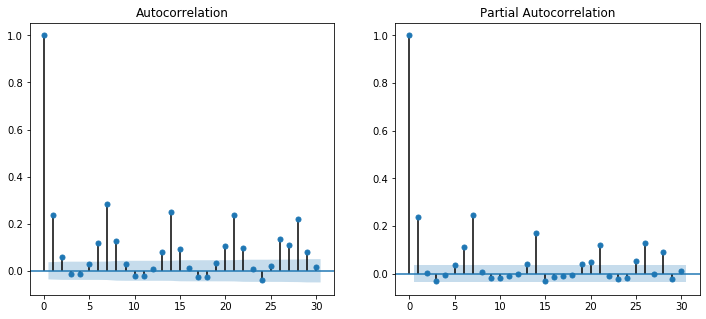

In [49]:
autocorr_plots(daily_avg_ts(11), lags=30)

In [50]:
find_best_params(daily_avg_ts(11))

,parameters,seasonal parameters,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",33975.098242
59,"(1, 1, 1)","(0, 1, 1, 12)",33979.741486
43,"(1, 0, 1)","(0, 1, 1, 12)",34039.877165
47,"(1, 0, 1)","(1, 1, 1, 12)",34041.596787
35,"(1, 0, 0)","(0, 1, 1, 12)",34049.551163
...,...,...,...
26,"(0, 1, 1)","(0, 1, 0, 12)",36319.310497
0,"(0, 0, 0)","(0, 0, 0, 12)",36531.719768
22,"(0, 1, 0)","(1, 1, 0, 12)",36634.965906
50,"(1, 1, 0)","(0, 1, 0, 12)",37215.318992


Root MSE:  95.56451557355335
R2 Score:  0.03422163920850341


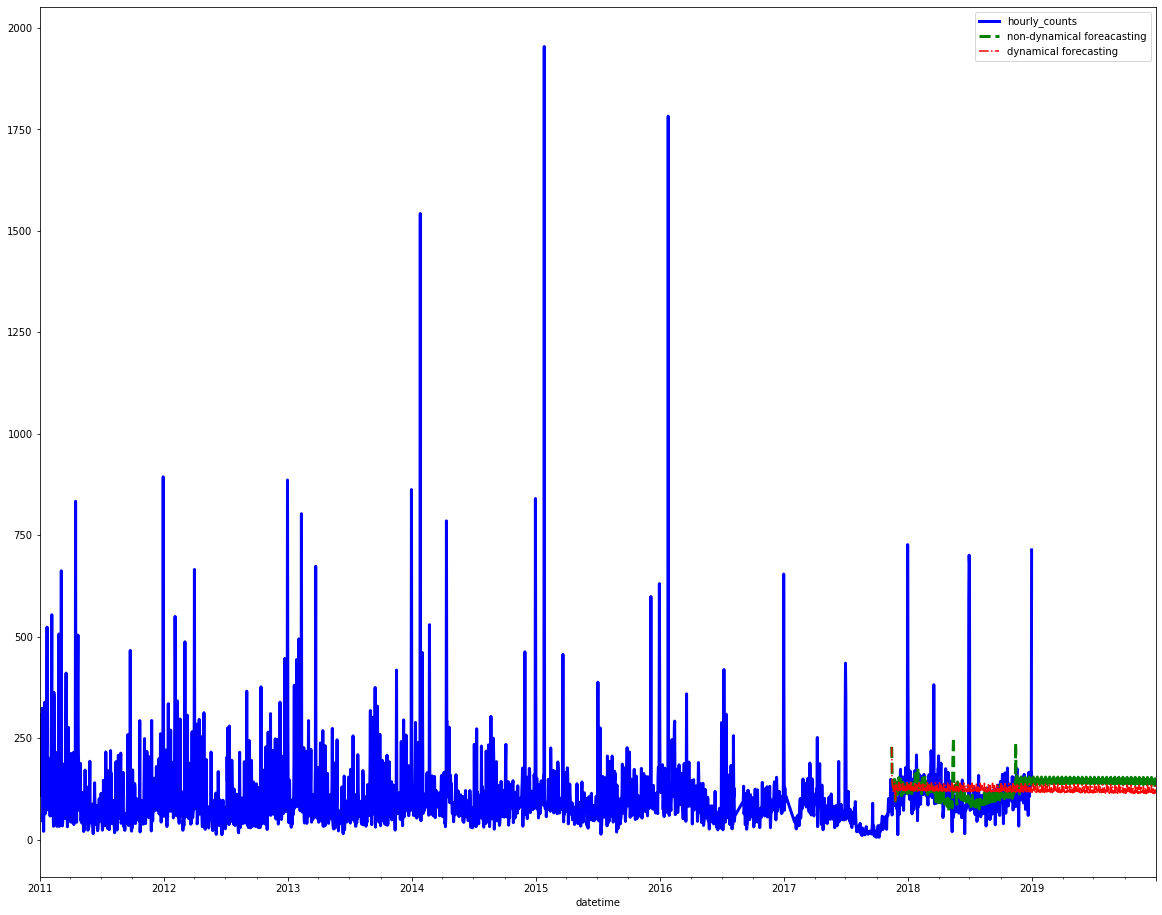

In [59]:
model_scores(daily_sensor = daily_avg_ts(11), order1 =1 , order2= 1, order3= 1, seasonal1 = 1, seasonal2=1, seasonal3 = 1, sensor_num = 11)



## Sensor 18

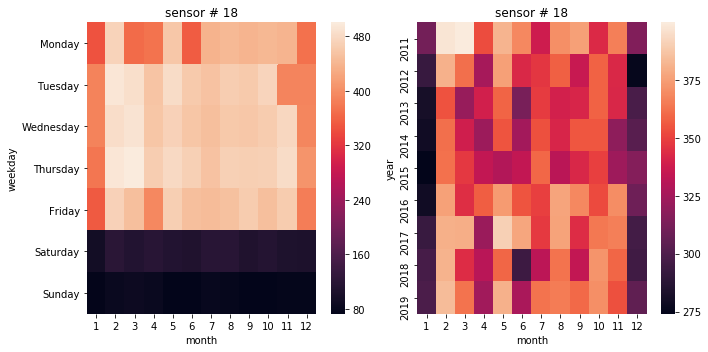

In [51]:
heatmap_per_sensor(18)

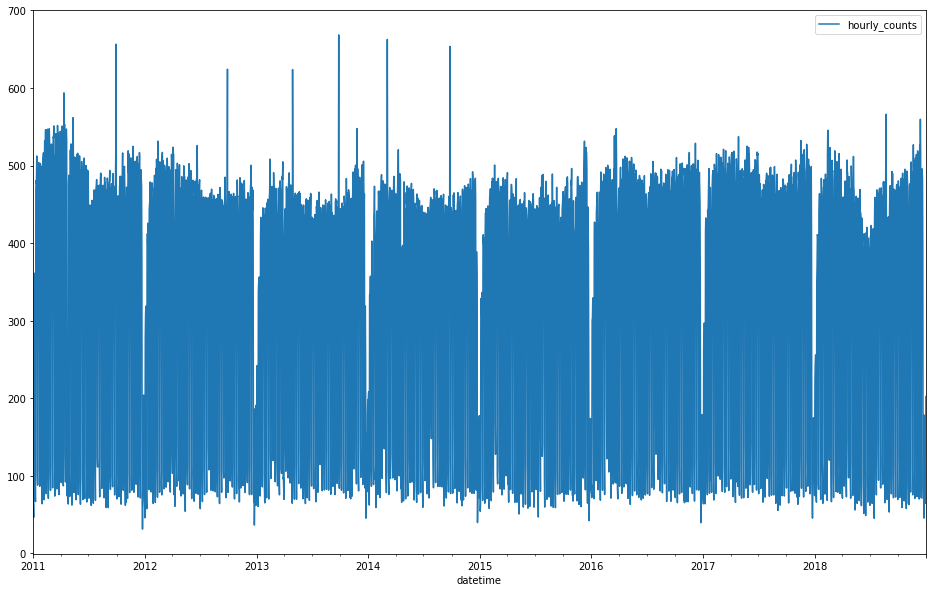

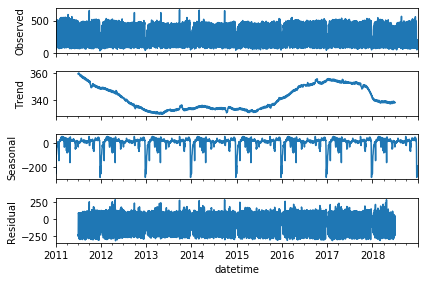

In [52]:
time_series_plots(daily_avg_ts(18))

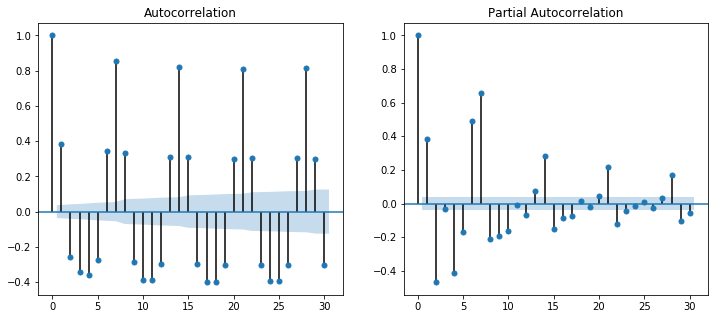

In [53]:
autocorr_plots(daily_avg_ts(18), lags=30)

In [54]:
find_best_params(daily_avg_ts(18))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,parameters,seasonal parameters,AIC
15,"(0, 0, 1)","(1, 1, 1, 12)",36997.214999
47,"(1, 0, 1)","(1, 1, 1, 12)",36999.135823
57,"(1, 1, 1)","(0, 0, 1, 12)",37024.660361
61,"(1, 1, 1)","(1, 0, 1, 12)",37024.747254
43,"(1, 0, 1)","(0, 1, 1, 12)",37168.605579
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 12)",41581.955519
26,"(0, 1, 1)","(0, 1, 0, 12)",41793.774074
18,"(0, 1, 0)","(0, 1, 0, 12)",41950.589855
50,"(1, 1, 0)","(0, 1, 0, 12)",41952.322447


Root MSE:  145.7127291765638
R2 Score:  0.3081763441683836


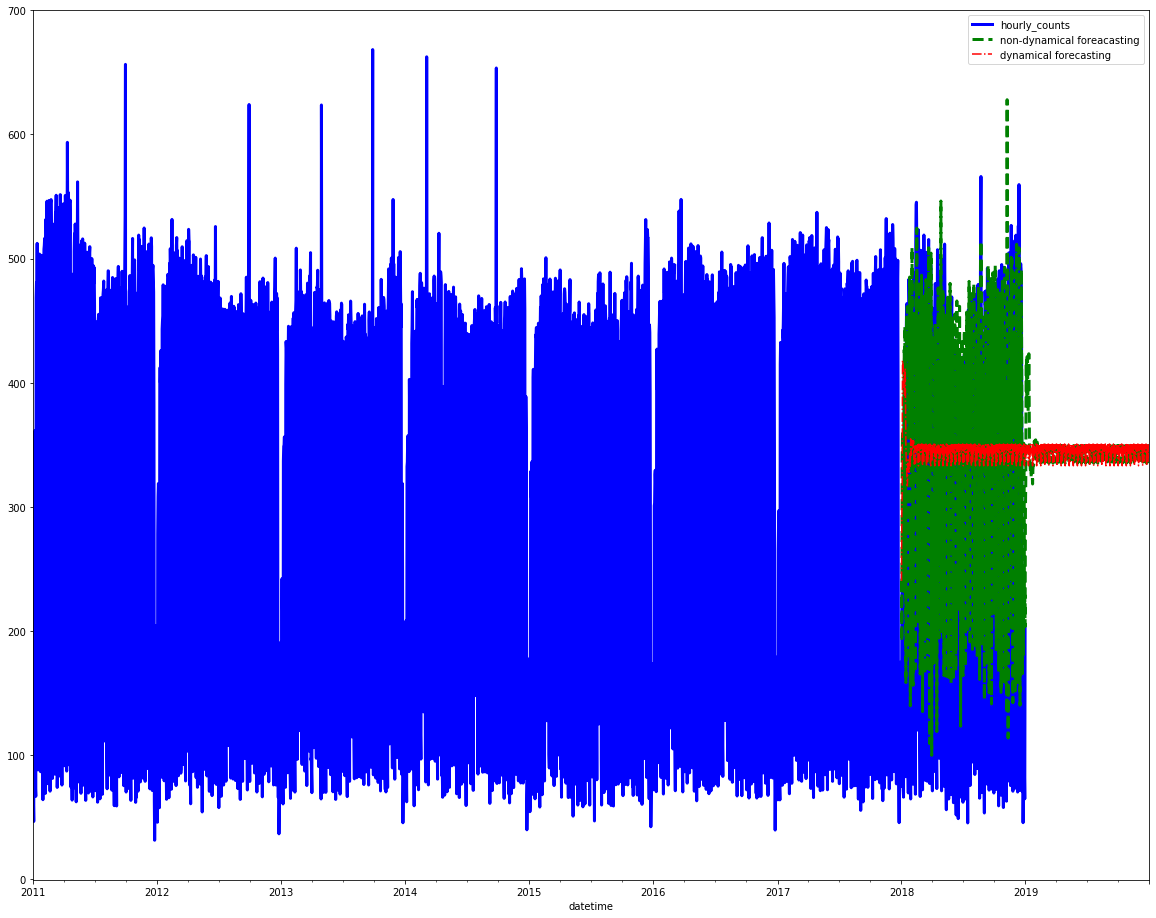

In [60]:
model_scores(daily_sensor = daily_avg_ts(18), order1 =0 , order2= 0, order3= 1, seasonal1 = 1, seasonal2=1, seasonal3 = 1, sensor_num = 18)

